# DNA meth level (uniCHM ov IAPEzint)

In [1]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
### get_methylation_levels.py -m $methfi -b ${beddirPrefix}_${feature}.bed -p 100 -o ${j}_${feature}.txt -c 1
def scan_meth_level_split2bins(meth_scan, name, capture_regions_file, samGbed_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    for index,samGbed in enumerate(samGbed_files) :
        meth_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/get_methylation_levels.py -m {samGbed} -p {capture_points} -b {capture_regions_file} -o signal_{name}_siteprof{index+1}.txt'
        if meth_scan :
#             print(meth_scan_cmd)
            print(subprocess.check_output(meth_scan_cmd.split()).decode(), end='')
    
    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (samGbed, label) in enumerate(zip(samGbed_files, labels)):
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.txt',
                                    sep=',',
                                    header=None,
                                    index_col=None,
                                    names=xticks)     
    return signal    

In [3]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [4]:
%%bash
### 5end 3end
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz
for bed in IAPEz_specific.bed IAPEz_universalCHM_overlap.bed universalCHM_IAPEz_overlap.bed universalCHM_specific.bed;do
    name=${bed%%.bed}
    awk 'BEGIN{FS=OFS="\t"}{print $1, $2-1, $2}' $bed > ${name}.5end.bed
    awk 'BEGIN{FS=OFS="\t"}{print $1, $3, $3+1}' $bed > ${name}.3end.bed
done

In [8]:
%%bash
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/DNAmeth/
ln -s ../*.bed .
ls


capture_regions.bed
IAPEz_specific.3end.bed
IAPEz_specific.5end.bed
IAPEz_specific.bed
IAPEz_universalCHM_overlap.3end.bed
IAPEz_universalCHM_overlap.5end.bed
IAPEz_universalCHM_overlap.bed
universalCHM_IAPEz_overlap.3end.bed
universalCHM_IAPEz_overlap.5end.bed
universalCHM_IAPEz_overlap.bed
universalCHM_specific.3end.bed
universalCHM_specific.5end.bed
universalCHM_specific.bed


In [15]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/DNAmeth')
signal_AB_dict = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict[end] = {}
    for t in ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'] :
        bed_fi = f'{t}.{end}.bed' if end != 'body' else f'{t}.bed'
        meth_scan = False if end != 'body' else False
#             resolution = 100 if end == 'body' else 5000
        left_span  = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000  # average Universal CHM length
        signal_AB_dict[end][t] = scan_meth_level_split2bins(
            meth_scan = meth_scan,
            name = f'DNAMeth_around_{t}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            samGbed_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/{process}/PreparedBeforeCallCHM/{stage}.methyl.sam.G.bed' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_DNAmeth' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [16]:
signal_AB_concat_dict = {}
for span in [50000] :
    signal_AB_concat_dict[span] = {}
    for t in ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'] :
        signal_AB_concat_dict[span][t] = {}
        for i,label in enumerate([f'{process}_{stage}_DNAmeth' for process in stage_dict.keys() for stage in stage_dict[process]]) :        
            signal_AB_concat_dict[span][t][label] = pd.concat([signal_AB_dict['5end'][t][label][np.arange(-span, 0, 100)], 
                                                               signal_AB_dict['body'][t][label], 
                                                               signal_AB_dict['3end'][t][label][np.arange(100, span+100, 100)]], axis = 1)
            body_len = signal_AB_dict['body'][t][label].columns[-1] - signal_AB_dict['body'][t][label].columns[0]
            signal_AB_concat_dict[span][t][label].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict['body'][t][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
                
signal_AB_concat_dict[span][t][label]

,-50000,-49900,-49800,-49700,-49600,-49500,-49400,-49300,-49200,-49100,...,54100,54200,54300,54400,54500,54600,54700,54800,54900,55000
0,NaN,0.937500,0.835821,NaN,NaN,NaN,0.800000,NaN,0.647059,0.954545,...,0.800000,NaN,NaN,0.852941,0.636364,0.952381,NaN,0.727273,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.000000,0.538462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.695652,NaN,NaN,NaN,NaN,NaN
2,0.466667,0.741935,NaN,NaN,NaN,NaN,0.611111,NaN,NaN,0.589744,...,0.800000,NaN,0.761905,NaN,NaN,NaN,0.650000,NaN,NaN,0.558824
3,NaN,NaN,0.421053,0.642857,0.115385,NaN,NaN,NaN,NaN,NaN,...,0.789474,0.608696,NaN,NaN,NaN,NaN,NaN,0.750000,NaN,0.909091
4,NaN,0.896552,NaN,NaN,0.677419,NaN,0.680000,NaN,NaN,0.727273,...,0.833333,0.888889,0.863636,NaN,0.894737,0.739130,0.809524,0.842105,0.891304,0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,NaN,NaN,NaN,NaN,0.846154,NaN,0.827586,NaN,NaN,NaN,...,0.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.878788
701,NaN,NaN,NaN,0.875000,NaN,0.857143,0.636364,0.850000,0.700000,0.666667,...,0.846154,NaN,NaN,0.166667,NaN,0.476190,NaN,NaN,NaN,0.615385
702,NaN,NaN,0.200000,0.576923,0.692308,0.560976,0.695652,0.533333,0.594595,NaN,...,0.685714,NaN,0.818182,NaN,NaN,NaN,NaN,0.625000,0.724138,0.942857
703,NaN,NaN,0.714286,0.761905,0.785714,0.842105,0.851064,NaN,0.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
colors = ['#4297A0', '#2F5061', '#E57F84', '#D4CAC6',]

In [23]:
stage_3_dict = {
 'EarlyEmbryogenesis': ['2cell', '8cell', 'ICM'],
 'PGCsDevelopment': ['E10.5', 'E13.5_female', 'E13.5_male'],
 'Spermatogenesis': ['US', 'DS', 'RS'],
 'RetinalDevelopment': ['E14.5', 'P0', 'P21'],
 'HeartDevelopment': ['E10.5', 'E13.5', 'P0'],
 'LiverDevelopment': ['E11.5', 'E14.5', 'P0']
}

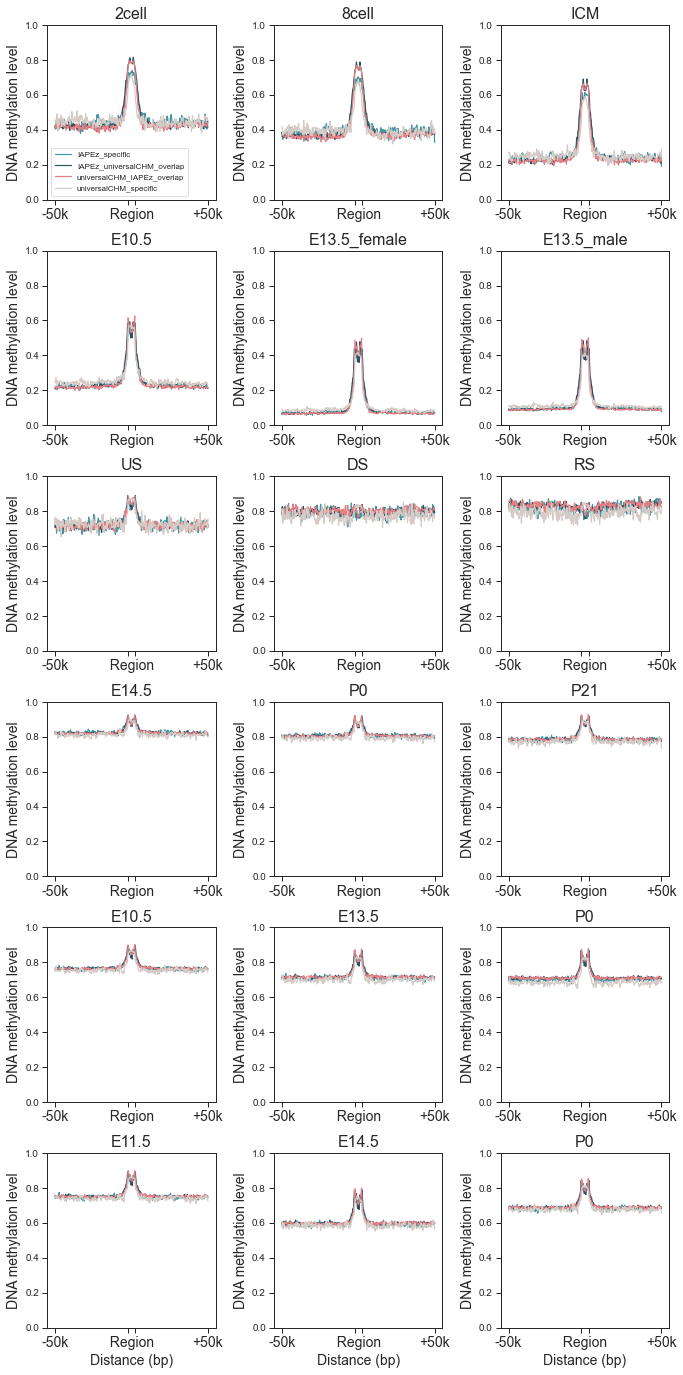

In [24]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 3, figsize=(6.4 * 1.5, 4.8 * 4), sharey = False, sharex = False, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_3_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_DNAmeth'
                for j,t in enumerate(['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific']) :
                    x = signal_AB_concat_dict[span][t][label].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][t][label].mean(), k = 1)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=t, color=colors[j])

                h, l = ax.get_legend_handles_labels()
                if a == 0 and b == 0 :
                    ax.legend(h, ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'], title='')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  Region", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance (bp)')
                ax.set_ylabel('DNA methylation level')
                ax.set_title(f'{stage}')

                ax.set_ylim(0,1)

#         fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_DNAmeth_3stages_UniversalCHM_overlap_ABcompart_{cell_type}_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        


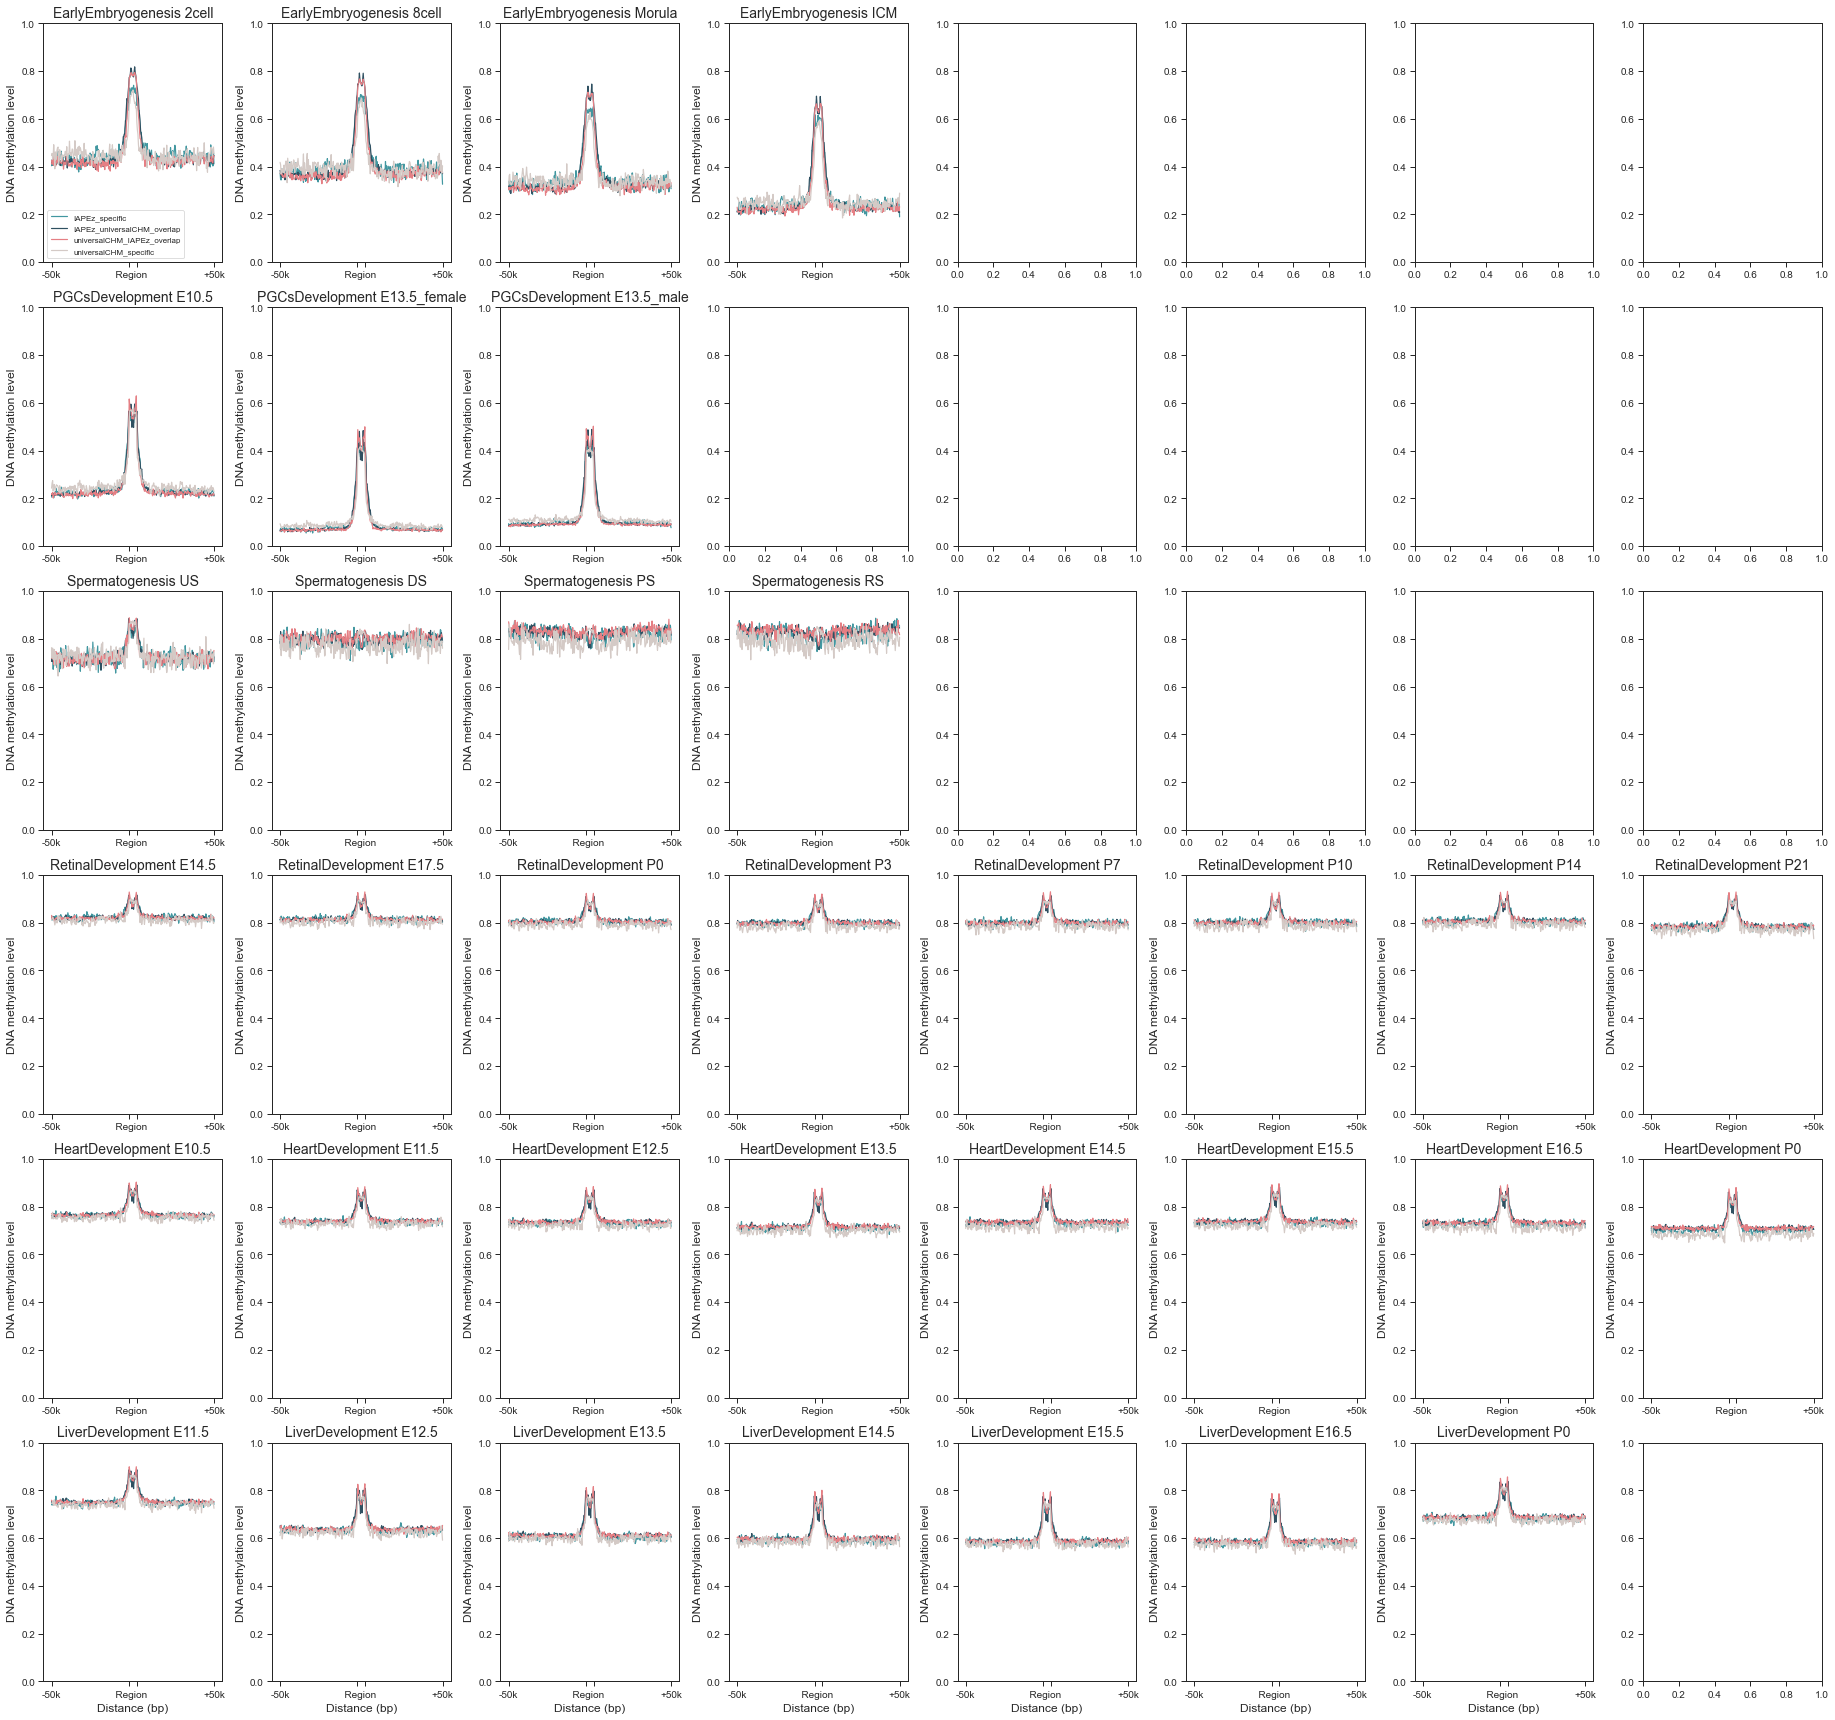

In [27]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = False, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_DNAmeth'
                for j,t in enumerate(['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific']) :
                    x = signal_AB_concat_dict[span][t][label].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][t][label].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=t, color=colors[j])
                    
                h, l = ax.get_legend_handles_labels()
                if a == 0 and b == 0 :
                    ax.legend(h, ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'], title='')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  Region", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance (bp)')
                ax.set_ylabel('DNA methylation level')
                ax.set_title(f'{process} {stage}')

                ax.set_ylim(0,1)

        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_DNAmeth_UniversalCHM_overlap_IAPEzint_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        
